In [1]:
import os
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae, max_peak_error, mean_n_peak_error

from utils import *
from train_eval import *
import warnings
warnings.filterwarnings('ignore')
# Set seed
np.random.seed(42)

In [2]:
# Set working directory
import wandb
wandb.login()

os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')
model_dir = os.path.join(os.getcwd(), 'models')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [13]:
locations_dict, resolutions_dict = get_hdf_keys(dir_path)




In [16]:
def training(scale, location):


    units_dict = {'county': 'GW', 'town': 'MW', 'village': 'kW', 'neighborhood': 'kW'}
    
    
    tuned_models = [
                    #'rf',
                    #'lgbm',
                     'xgb',
                    # 'gru',
                    # 'nbeats'
                    ]

    resolution = 60


    config_per_model = {}
    for model in tuned_models:
        config, name = get_best_run_config('Wattcast_tuning', '+eval_loss', model, scale)
        config['horizon_in_hours'] = 48
        config['location'] = location 
        config_per_model[model] = config, name


    wandb.finish()


    name_id = scale + "_" + location + "_" + str(resolution) + "min"
    wandb.init(project="Wattcast2", name=name_id, id = name_id)


    config = Config().from_dict(config_per_model[tuned_models[0]][0])

    pipeline, ts_train_piped, ts_val_piped, ts_test_piped, ts_train_weather_piped, ts_val_weather_piped, ts_test_weather_piped, trg_train_inversed, trg_val_inversed, trg_test_inversed = data_pipeline(config)

    model_instances = get_model_instances(tuned_models, config_per_model)

    trained_models, model_instances = load_trained_models(config, model_instances)


    if len(model_instances) > 0:
        just_trained_models, run_times = train_models(model_instances.values(), 
                                ts_train_piped,
                                ts_train_weather_piped if config.weather else None, 
                                ts_val_piped,
                                ts_val_weather_piped if config.weather else None,
                                )
        
        df_runtimes = pd.DataFrame.from_dict(run_times, orient='index', columns=['runtime']).reset_index()
        wandb.log({"runtimes": wandb.Table(dataframe=df_runtimes)})
        trained_models.extend(just_trained_models)

    
    models_dict = {model.__class__.__name__: model for model in trained_models}
    save_models_to_disk(config, models_dict)

    config.model_names = list(models_dict.keys())

    config.unit = units_dict[scale.split('_')[1]]

    wandb.config.update(config.data)
    


    return config, models_dict





def evaluation(config, models_dict):
    
    pipeline, ts_train_piped, ts_val_piped, ts_test_piped, ts_train_weather_piped, ts_val_weather_piped, ts_test_weather_piped, trg_train_inversed, trg_val_inversed, trg_test_inversed = data_pipeline(config)
    
    test_sets = { # see data_prep.ipynb for the split
            "Winter": (
                        ts_val_piped[config.longest_ts_val_idx], 
                        None if not config.weather else ts_val_weather_piped[config.longest_ts_val_idx],
                        trg_val_inversed
                        ), 
            "Summer": (
                        ts_test_piped[config.longest_ts_test_idx],
                        None if not config.weather else ts_test_weather_piped[config.longest_ts_test_idx],
                        trg_test_inversed
                        )
                        }
    


    dict_result_season = _eval(models_dict, pipeline, test_sets, config)

    dict_result_n_ahead = extract_forecasts_per_horizon(config, dict_result_season)

    return dict_result_n_ahead

def _eval(models_dict, pipeline, test_sets, config):
    dict_result_season = {}
    for season, (ts, ts_cov, gt) in test_sets.items():
        print(f"Testing on {season} data")
        # Generating Historical Forecasts for each model
        ts_predictions_per_model = {}
        historics_per_model = {}
        for model_name, model in models_dict.items():
            print(f"Generating historical forecasts with {model_name}")
            historics = model.historical_forecasts(ts, 
                                                future_covariates= ts_cov if model.supports_future_covariates else None,
                                                start=ts.get_index_at_point(config.n_lags),
                                                verbose=True,
                                                stride= 1, # this allows us to later differentiate between the different horizons
                                                forecast_horizon= config.timesteps_per_hour*48, # 48 hours is our max horizon
                                                retrain=False, 
                                                last_points_only=False,
                                                )
            
            historics_inverted = [pipeline.inverse_transform(historic) for historic in historics][1:] # the first historic is partly nan, so we skip it
            historics_per_model[model_name] = historics_inverted # storing the forecasts in batches of the forecasting horizon, for plot 2
        
        dict_result_season[season] = historics_per_model, gt

    return dict_result_season




def extract_forecasts_per_horizon(config, dict_result_season):

    n_aheads = [i * config.timesteps_per_hour for i in [
                                                        1, 
                                                        4, 
                                                        8, 
                                                        24, 
                                                        48
                                                        ]] # horizon in hours
    dict_result_n_ahead = {}

    for n_ahead in n_aheads:
        dict_result_season_update = {}
        for season, (historics_per_model, gt) in dict_result_season.items():
            ts_predictions_per_model = {}
            historics_per_model_update = {}
            for model_name, historics in historics_per_model.items():

                ts_predictions = ts_list_concat_new(historics, n_ahead)
                ts_predictions_per_model[model_name] = ts_predictions
                historics_per_model_update[model_name] = historics

            ts_predictions_per_model['24-Hour Persistence'] = gt.shift(config.timesteps_per_hour*24) # adding the 24-hour persistence model as a benchmark
            dict_result_season_update[season] = historics_per_model_update, ts_predictions_per_model, gt
        dict_result_n_ahead[n_ahead] = dict_result_season_update

    return dict_result_n_ahead



def get_run_results(dict_result_n_ahead, config):
    
    

    df_metrics = error_metrics_table(dict_result_n_ahead, config)

    side_by_side(dict_result_n_ahead, config)

    error_metric_trajectory(dict_result_n_ahead, config)

    error_distribution(dict_result_n_ahead, config)

    daily_sum(dict_result_n_ahead, config)


    return df_metrics





def error_metrics_table(dict_result_n_ahead, config):

    print("Calculating error metrics")
    
    list_metrics = [rmse, r2_score, mae, smape, mape, max_peak_error , mean_n_peak_error] # evaluation metrics

    metrics_tables = []

    for n_ahead, dict_result_season in dict_result_n_ahead.items():
        for season, (_, preds_per_model, gt) in dict_result_season.items():
            df_metrics = get_error_metric_table(list_metrics, preds_per_model, gt)
            rmse_persistence = df_metrics.loc[df_metrics.index == '24-Hour Persistence', 'rmse'].values[0]
            df_metrics.drop(labels= [config.model_names[-1]], axis = 0, inplace=True)
            df_metrics.reset_index(inplace=True)
            df_metrics['season'] = season
            df_metrics.set_index('season', inplace=True)
            df_metrics.reset_index(inplace=True)
            df_metrics['horizon_in_hours'] = n_ahead//config.timesteps_per_hour
            df_metrics.set_index('horizon_in_hours', inplace=True)
            df_metrics.reset_index(inplace=True)
            df_metrics['rmse_skill_score'] = 1 - df_metrics['rmse'] / rmse_persistence
            metrics_tables.append(df_metrics)

    df_metrics = pd.concat(metrics_tables, axis=0, ignore_index=True).sort_values(by=['season', 'horizon_in_hours'])
    wandb.log({f"Error metrics": wandb.Table(dataframe=df_metrics)})

    return df_metrics


def side_by_side(dict_result_n_ahead, config):

    print("Plotting side-by-side comparison of predictions and the ground truth")
    
    df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_cov')
    df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_cov')
    df_cov_test = pd.read_hdf(os.path.join(dir_path,f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_cov')
    
    
    temp_data = {'Summer': df_cov_test.iloc[:,0], 'Winter': df_cov_val.iloc[:,0]}


    for n_ahead, dict_result_season in dict_result_n_ahead.items():

        for season, (_, preds_per_model, gt) in dict_result_season.items():
            fig = go.Figure()

            # Add the ground truth data to the left axis
            fig.add_trace(go.Scatter(x=gt.pd_series().index, y=gt.pd_series().values, name="Ground Truth", yaxis="y1"))

            for model_name in config.model_names:
                preds = preds_per_model[model_name]
                fig.add_trace(go.Scatter(x=preds.pd_series().index, y=preds.pd_series().values, name=model_name, yaxis="y1"))

            # Add the df_cov_test data to the right axis
            
            series_weather = temp_data[season]
            fig.add_trace(go.Scatter(
            x=series_weather.index,
            y=series_weather.values,
            name="temperature",
            yaxis="y2",
            line=dict(dash="dot", color = 'grey'),  # Set the line style to dotted
        ))

            fig.update_layout(
                title=f"{season} - Horizon: {n_ahead// config.timesteps_per_hour} Hours",
                xaxis=dict(title="Time"),
                yaxis=dict(title=f"Power [{config.unit}]", side="left"),
                yaxis2=dict(title="Temperature [°C]", overlaying="y", side="right"),
            )

            wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth": fig})



def error_metric_trajectory(dict_result_n_ahead, config):

    print("Plotting error metric trajectory")

    n_ahead, dict_result_season = list(dict_result_n_ahead.items())[-1]

    dict_result_season = dict_result_n_ahead[n_ahead]
    df_smapes_per_season = {}
    df_nrmse_per_season = {}

    for season, (historics_per_model, _, gt) in dict_result_season.items():
        df_smapes_per_model = []
        df_rmse_per_model = []
        for model_name, historics in historics_per_model.items():
            df_list = get_df_compares_list(historics, gt)
            diffs = get_df_diffs(df_list)
            df_smapes = abs(diffs).mean(axis =1) 
            df_smapes.columns = [model_name]
            df_rmse = np.square(diffs).mean(axis =1) 
            df_rmse.columns = [model_name]

            df_smapes_per_model.append(df_smapes)
            df_rmse_per_model.append(df_rmse)

        df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1).ewm(alpha=0.1).mean()
        df_smapes_per_model.columns = config.model_names
        df_nrmse_per_model = pd.concat(df_rmse_per_model, axis=1).ewm(alpha=0.1).mean()
        df_nrmse_per_model.columns = config.model_names
        df_smapes_per_season[season] = df_smapes_per_model
        df_nrmse_per_season[season] = df_nrmse_per_model

    for season in dict_result_season.keys():
        fig = df_smapes_per_season[season].plot(figsize=(10,5))
        plt.xlabel('Horizon')
        plt.ylabel('MAPE [%]')
        plt.legend(loc = 'upper left', ncol = 2)
        plt.xticks(np.arange(0, n_ahead, 2))
        plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {season}")
        wandb.log({f"MAPE of the Historical Forecasts in {season}": wandb.Image(fig)})
        
    for season in dict_result_season.keys():
        fig = df_nrmse_per_season[season].plot(figsize=(10,5))
        plt.xlabel('Horizon')
        plt.ylabel(f'RMSE [{config.unit}]')
        plt.xticks(np.arange(0, n_ahead, 2))
        plt.legend(loc = 'upper left', ncol = 2)
        plt.title(f"Root Mean Squared Error of the Historical Forecasts in {season}")
        wandb.log({f"RMSE of the Historical Forecasts in {season}": wandb.Image(fig)})



def error_distribution(dict_result_n_ahead, config):

    print("Plotting error distribution")

    n_ahead, dict_result_season = list(dict_result_n_ahead.items())[-1]
    for season, (historics_per_model, _, gt) in dict_result_season.items():
        df_smapes_per_model = []
        df_nrmse_per_model = []
        fig, ax = plt.subplots(ncols=len(config.model_names), figsize=(5*len(config.model_names),5))
        fig.suptitle(f"Error Distribution of the Historical Forecasts in {season}")
        for i, (model_name, historics) in enumerate(historics_per_model.items()):
            df_list = get_df_compares_list(historics, gt)
            diffs = get_df_diffs(df_list)
            diffs_flat = pd.Series(diffs.values.reshape(-1,))
            ax[i].hist(diffs_flat, bins=100)
            ax[i].set_title(model_name)
        
        wandb.log({f"Error Distribution of the Historical Forecasts in {season}": wandb.Image(fig)})




def daily_sum(dict_result_n_ahead, config):

    print("Plotting daily sum of the predictions and the ground truth")

    dict_result_season = dict_result_n_ahead[list(dict_result_n_ahead.keys())[-1]]
    for season, (_, preds_per_model, gt) in dict_result_season.items():
        dfs_daily_sums = []
        for model_name, preds in preds_per_model.items():
            df_preds = preds.pd_series().to_frame(model_name + "_preds")
            z = df_preds.groupby(df_preds.index.date).sum()
            dfs_daily_sums.append(z)

        df_gt = gt.pd_series().to_frame("ground_truth") 
        z = df_gt.groupby(df_gt.index.date).sum() / config.timesteps_per_hour
        dfs_daily_sums.append(z)
        df_compare = pd.concat(dfs_daily_sums, axis=1).dropna()
        fig = df_compare[:10].plot(kind='bar', figsize=(20,10))
        plt.legend(loc = 'upper right', ncol = 2)
        plt.ylabel(f'Energy [{config.unit}h]')
        plt.title(f"Daily Sum of the Predictions and the Ground Truth in {season}")
        wandb.log({f"Daily Sum of the Predictions and the Ground Truth in {season}": wandb.Image(fig)})





Training Los_Angeles at 1_county scale


wandb: Sorting runs by +summary_metrics.eval_loss


getting model instance for xgb
getting model instance for linear regression
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models\1_county_Los_Angeles
c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models
Directory already exists: c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models\1_county_Los_Angeles
c:\Users\nik\Desktop\Berkeley_Projects\WattCast\models
Testing on Winter data
Generating historical forecasts with XGBModel


  0%|          | 0/697 [00:00<?, ?it/s]

Generating historical forecasts with LinearRegressionModel


  0%|          | 0/697 [00:00<?, ?it/s]

Testing on Summer data
Generating historical forecasts with XGBModel


  0%|          | 0/697 [00:00<?, ?it/s]

Generating historical forecasts with LinearRegressionModel


  0%|          | 0/697 [00:00<?, ?it/s]

Calculating error metrics
Plotting side-by-side comparison of predictions and the ground truth
Plotting error metric trajectory
Plotting error distribution
Plotting daily sum of the predictions and the ground truth


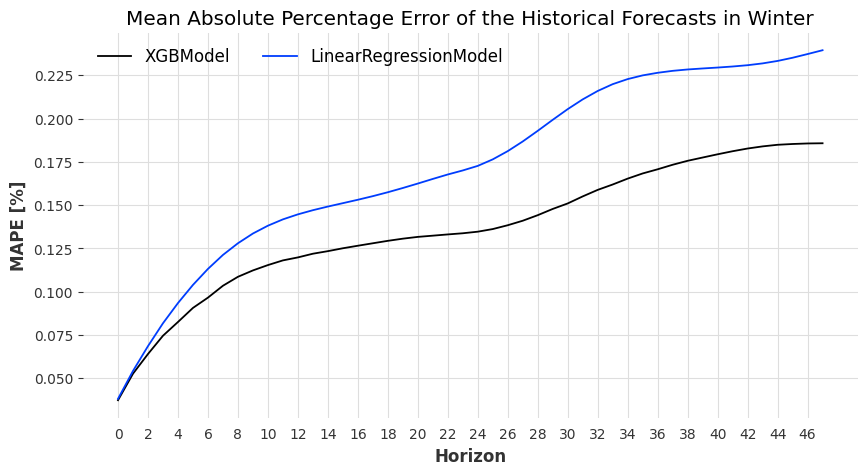

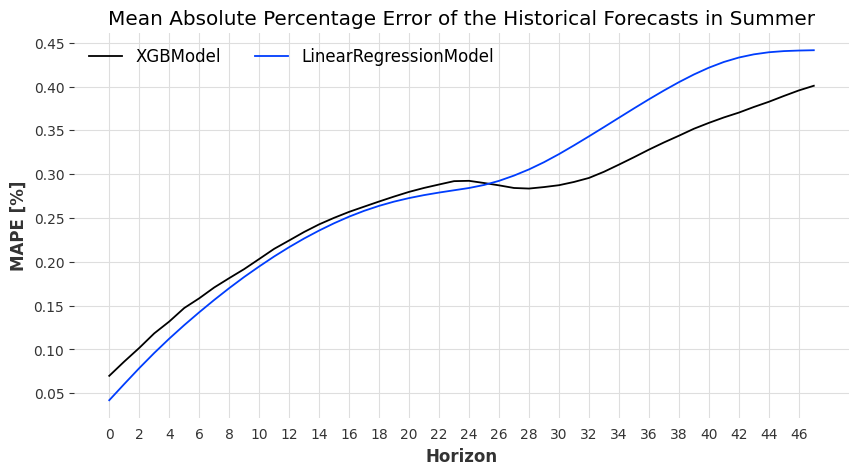

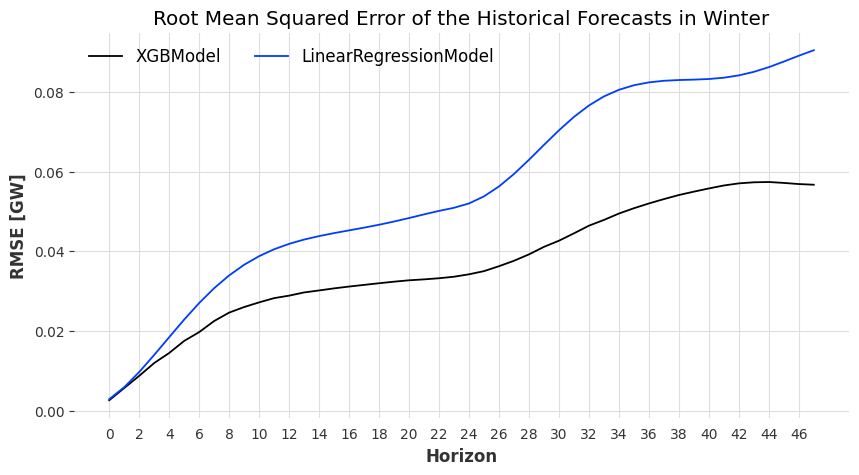

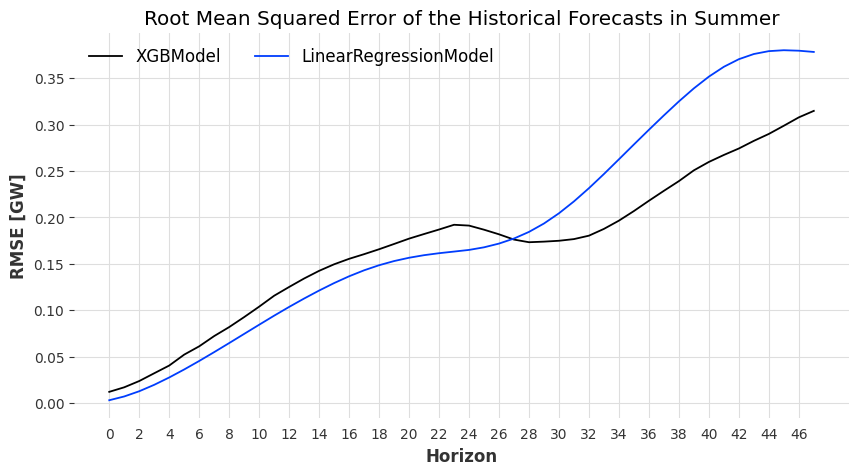

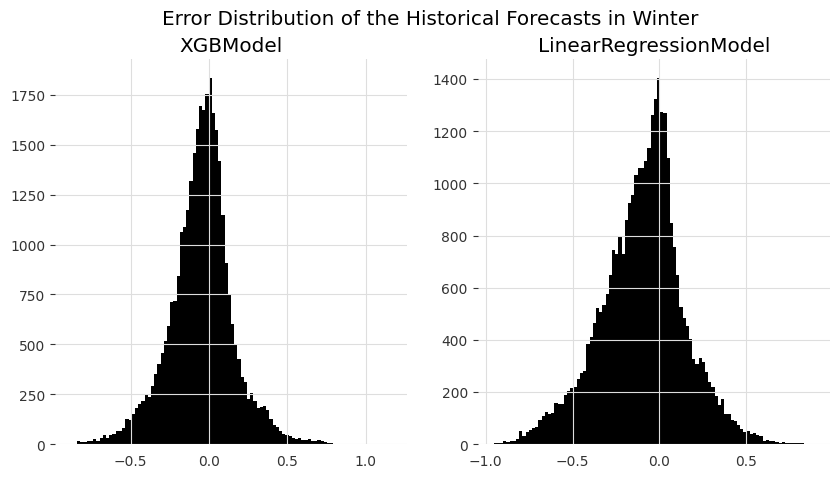

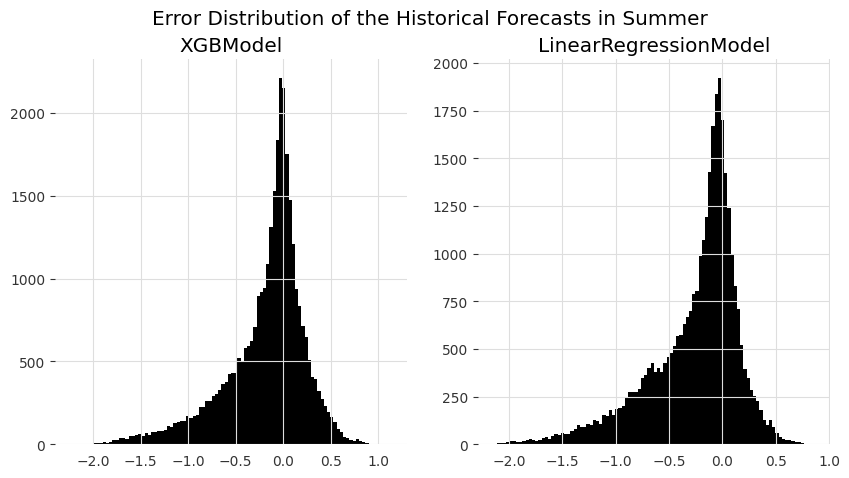

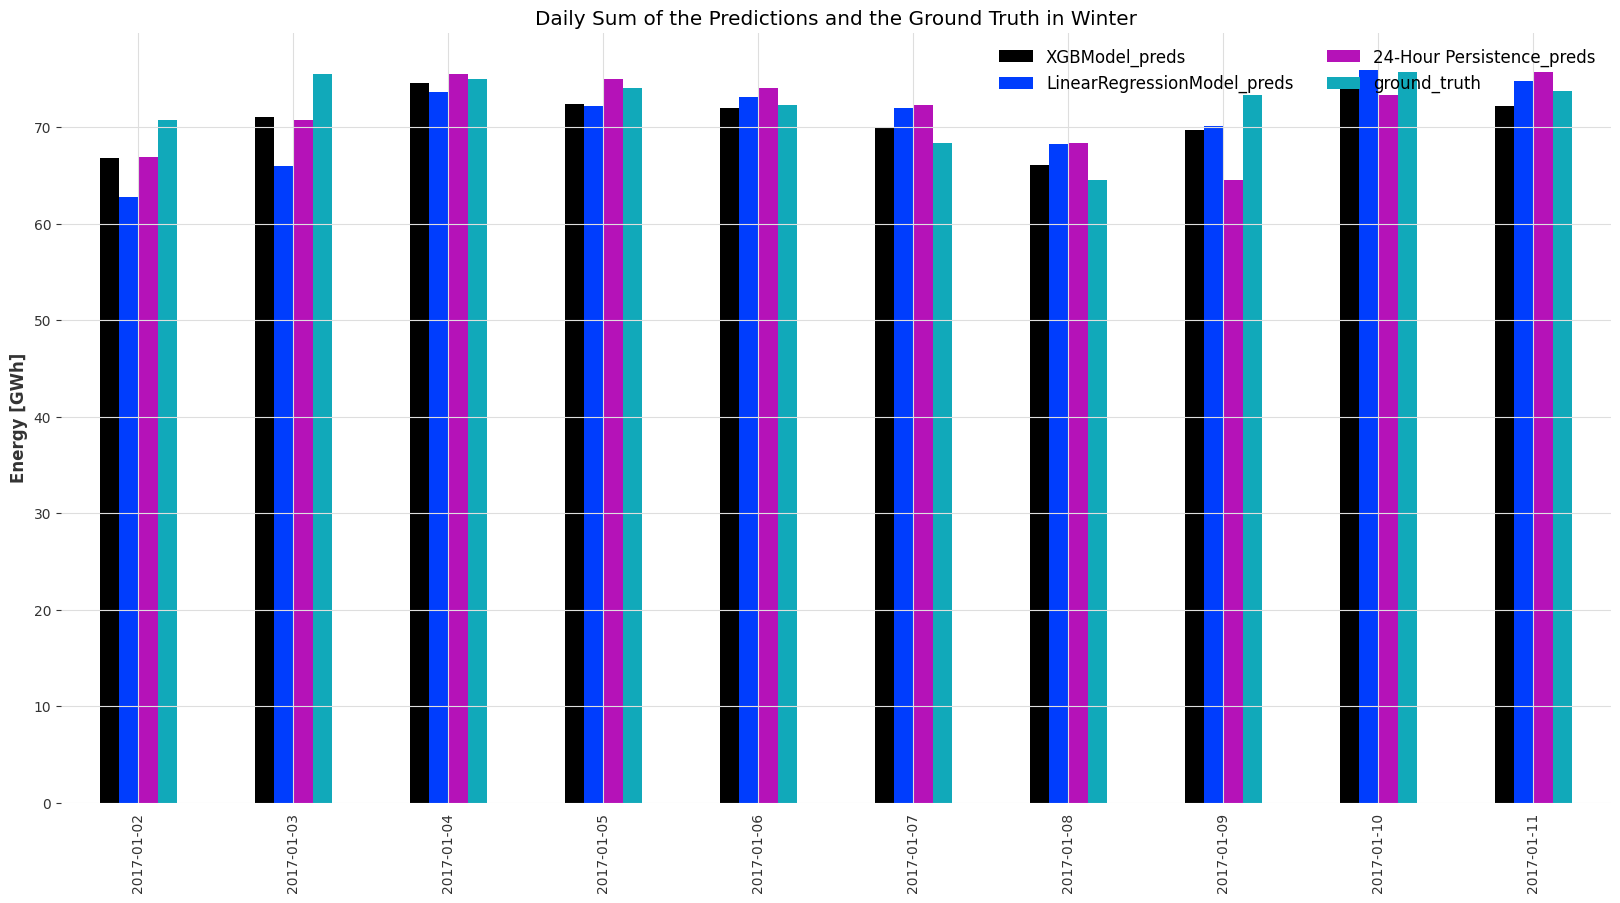

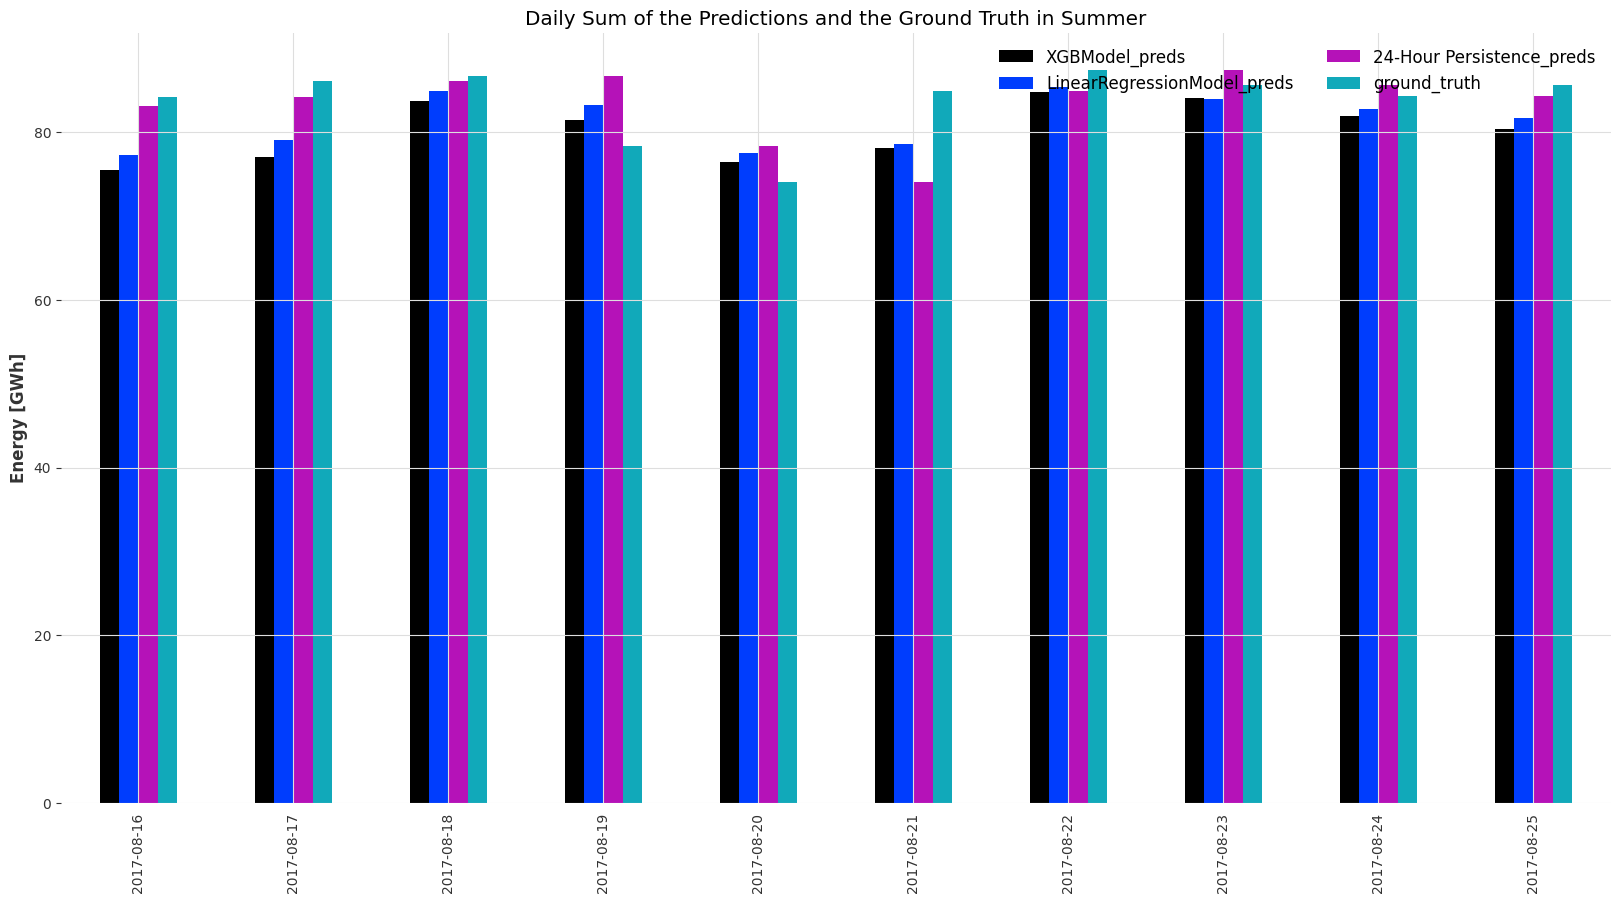

In [12]:
for scale, locations in locations_dict.items():

    scale = scale.split('.')[0]
    for location in locations:

        print(f"Training {location} at {scale} scale")

        config, models = training(scale, location)

        eval_dict = evaluation(config, models)

        df_metrics = get_run_results(eval_dict, config)

        #wandb.finish()

        break
    break

,horizon_in_hours,season,model,rmse,r2_score,mae,smape,mape,max_peak_error,mean_n_peak_error,rmse_skill_score
2,1,Summer,LightGBMModel,0.118480,0.986138,0.072956,1.693105,1.694496,0.597156,0.735156,0.687705
3,1,Summer,24-Hour Persistence,0.379383,0.864045,0.275493,6.705757,6.785168,0.188000,0.034000,0.000000
6,4,Summer,LightGBMModel,0.182492,0.965553,0.120682,2.893905,2.918497,0.759096,0.759096,0.518979
7,4,Summer,24-Hour Persistence,0.379383,0.864045,0.275493,6.705757,6.785168,0.188000,0.034000,0.000000
10,8,Summer,LightGBMModel,0.239399,0.937989,0.150470,3.513736,3.566242,0.759096,0.759096,0.368980
11,8,Summer,24-Hour Persistence,0.379383,0.864045,0.275493,6.705757,6.785168,0.188000,0.034000,0.000000
14,24,Summer,LightGBMModel,0.403218,0.788111,0.275221,6.279016,6.501717,0.500813,0.580813,-0.062824
15,24,Summer,24-Hour Persistence,0.379383,0.864045,0.275493,6.705757,6.785168,0.188000,0.034000,0.000000
18,48,Summer,LightGBMModel,0.459460,0.694102,0.320378,7.475226,7.841663,0.818248,0.818248,-0.211070
19,48,Summer,24-Hour Persistence,0.379383,0.864045,0.275493,6.705757,6.785168,0.188000,0.034000,0.000000
